# Funções de janela para análise de dados
<p><img src = https://sp-ao.shortpixel.ai/client/q_glossy,ret_img,w_780,h_450/https://blog.academiain1.com.br/wp-content/uploads/2017/08/104629-big-data-voce-conhece-os-4-tipos-de-analise-de-dados-780x450.jpg width = 500></p>

## Introdução
No módulo anterior, discutimos funções agregadas, funções que podem receber um grande grupo de linhas e gerar um único valor para elas. Muitas vezes, ser capaz de resumir um grupo de linhas em um único valor é importante e útil. No entanto, há momentos em que você deseja manter as linhas individuais, além de obter um valor resumido. Para fazer isso, neste módulo, apresentaremos um novo conjunto de funções chamadas **funções de janela**, que podem calcular estatísticas agregadas mantendo linhas individuais. Estas funções são muito úteis para poder calcular novos tipos de estatísticas, como classificações e médias móveis, com relativa facilidade no SQL. Neste módulo, aprenderemos o que são funções de janela e como podemos usá-las para calcular estatísticas.

## Funções da janela
As funções agregadas nos permitem pegar muitas linhas e converter essas linhas em um número. Por exemplo, a função **COUNT** recebe as linhas de uma tabela e retorna o número de linhas que existem. No entanto, às vezes queremos poder calcular várias linhas, mas ainda manter todas as linhas após o cálculo. Por exemplo, digamos que você queira classificar todos os usuários em ordem de acordo com o momento em que se tornaram clientes, com o primeiro cliente sendo classificado como 1, o segundo cliente mais antigo classificado como 2 e assim por diante. Você pode obter todos os clientes usando a seguinte consulta:

In [31]:
import pandas as pd
import psycopg2 as pg

# Realizando a conexão local no Banco de dados (SQLDA)
connection = pg.connect(user="postgres",
                        password="admin",
                        host="127.0.0.1",
                        port="5432",
                        database="sqlda")
# Query a ser realizada

sql = """
      SELECT *
      FROM customers
      ORDER BY date_added;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,6173,None,Danila,Gristwood,None,dgristwood4rg@furl.net,F,254.239.58.108,832-157-3870,79865 Hagan Terrace,Katy,TX,77493,29.8678,-95.8298,2010-03-15
1,2625,None,Binky,Dawtrey,None,bdawtrey20w@shareasale.com,M,15.75.236.78,804-990-4322,0353 Iowa Road,Richmond,VA,23208,37.5593,-77.4471,2010-03-15
2,7486,None,Ciro,Ferencowicz,None,cferencowicz5rx@ucoz.ru,M,8.151.167.184,786-458-8754,61 Village Crossing,Miami,FL,33111,25.5584,-80.4582,2010-03-15
3,13390,None,Danika,Lough,None,dloughabx@skype.com,F,188.19.7.207,212-769-6845,38463 Forest Dale Way,New York City,NY,10019,40.7651,-73.9858,2010-03-15
4,12484,None,Lillis,Brayley,None,lbrayley9mr@ovh.net,F,253.224.181.145,None,None,None,None,None,NaN,NaN,2010-03-15


Você pode solicitar clientes do mais antigo ao mais recente, mas não pode atribuir um número a eles. Você pode usar uma função agregada para obter as datas e ordená-las dessa maneira:

In [32]:
sql = """
      SELECT date_added, COUNT(*)
      FROM customers
      GROUP BY date_added
      ORDER BY date_added;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,date_added,count
0,2010-03-15,11
1,2010-03-16,13
2,2010-03-17,12
3,2010-03-18,19
4,2010-03-19,23


Embora isso forneça as datas, ele elimina o restante das colunas e ainda não fornece informações de classificação. O que podemos fazer? É aqui que as funções da janela entram em jogo. As funções de janela podem pegar várias linhas de dados e processá-las, mas ainda retêm todas as informações nas linhas. Para coisas como classificações, isso é exatamente o que você precisa. Para melhor compreensão, vamos ver como é uma consulta de função do Windows na próxima seção.

### Noções básicas de funções de janela
A seguir está a sintaxe básica de uma função de janela:

`SELECT {columns},`

`{window_func} OVER (PARTITION BY {partition_key} ORDER BY {order_key})`

`FROM table1;`

Onde **{columns}** são as colunas a serem recuperadas das tabelas para a consulta, **{window_func}** é a função de janela que você deseja usar, **{partition_key}** é a coluna ou colunas nas quais você deseja particionar (mais sobre isso posteriormente), **{order_key}** é a coluna ou colunas pelas quais você deseja ordenar e **table1** é a tabela ou tabelas unidas das quais você deseja extrair dados. A palavra-chave **OVER** indica onde a definição da janela começa.

Para ilustrar, vamos usar um exemplo. Você pode estar dizendo a si mesmo que não conhece nenhuma função de janela, mas a verdade é que você conhece! Todas as funções agregadas podem ser usadas como funções de janela. Vamos usar **COUNT(*)** na seguinte consulta:

In [33]:
sql = """
      SELECT customer_id, title, first_name, last_name, gender,
      COUNT(*) OVER () as total_customers
      FROM customers
      ORDER BY customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,gender,total_customers
0,1,None,Arlena,Riveles,F,50000
1,2,Dr,Ode,Stovin,M,50000
2,3,None,Braden,Jordan,M,50000
3,4,None,Jessika,Nussen,F,50000
4,5,None,Lonnie,Rembaud,F,50000


Como pode ser visto na tabela acima, a consulta dos **costumers** retorna **title**, **first_name** e **last_name**, exatamente como uma consulta **SELECT** típica. No entanto, agora há uma nova coluna chamada **total_customers**. Esta coluna contém a contagem de usuários que seriam criados pela seguinte consulta:

In [34]:
sql = """
      SELECT COUNT(*)
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,count
0,50000


Isso retornou **50.000**. Conforme discutido, a consulta retornou todas as linhas e o **COUNT(*)** na consulta, em vez de apenas retornar a contagem como uma função agregada normal faria.

Agora, vamos examinar os outros parâmetros da consulta. O que acontece se usarmos **PARTITION BY**, como na consulta a seguir?

In [35]:
sql = """
      SELECT customer_id, title, first_name, last_name, gender,
      COUNT(*) OVER (PARTITION BY gender) as total_customers
      FROM customers
      ORDER BY customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,gender,total_customers
0,1,None,Arlena,Riveles,F,25044
1,2,Dr,Ode,Stovin,M,24956
2,3,None,Braden,Jordan,M,24956
3,4,None,Jessika,Nussen,F,25044
4,5,None,Lonnie,Rembaud,F,25044


Aqui, você verá que **total_customers** agora alterou as contagens para um dos dois valores, **24.956** ou **25.044**. Essas contagens são as contagens para cada **sexo**, que você pode ver com a seguinte consulta:

In [36]:
sql = """
      SELECT gender, COUNT(*)
      FROM customers
      GROUP BY gender;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,gender,count
0,M,24956
1,F,25044


Para as mulheres, a contagem é igual à contagem feminina e, para os homens, a contagem é igual à contagem masculina. O que acontece agora se usarmos **ORDER BY** na partição, como segue?

In [37]:
sql = """
      SELECT customer_id, title, first_name, last_name, gender,
      COUNT(*) OVER (ORDER BY customer_id) as total_customers
      FROM customers
      ORDER BY customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,gender,total_customers
0,1,None,Arlena,Riveles,F,1
1,2,Dr,Ode,Stovin,M,2
2,3,None,Braden,Jordan,M,3
3,4,None,Jessika,Nussen,F,4
4,5,None,Lonnie,Rembaud,F,5


Você notará algo semelhante a uma contagem contínua para o total de clientes. O que está acontecendo? É daí que vem a "janela" na função de janela. Quando você usa uma função de janela, a consulta cria uma "janela" sobre a tabela na qual ela baseia a contagem. **PARTITION BY** funciona como **GROUP BY**, dividindo o conjunto de dados em vários grupos. Para cada grupo, uma janela é criada. Quando **ORDER BY** não é especificado, assume-se que a janela é o grupo inteiro. No entanto, quando **ORDER BY** é especificado, as linhas do grupo são ordenadas de acordo com ele e, para cada linha, é criada uma janela sobre a qual uma função é aplicada. Sem especificar uma janela, o comportamento padrão é criar uma janela para abranger cada linha desde a primeira linha com base em **ORDER BY** até a linha atual sendo avaliada por uma função, conforme mostrado na Figura 5.5. É sobre esta janela que a função é aplicada.

Conforme mostrado na Figura 5.5, a janela da primeira linha contém uma linha e retorna uma contagem de 1, a janela da segunda linha contém duas linhas e retorna uma contagem de 2, enquanto a janela da terceira linha contém três linhas e, portanto, retorna uma contagem de 3 na coluna total_customers:

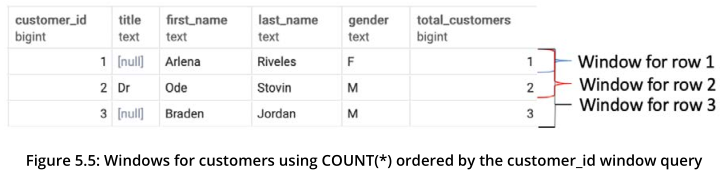

In [38]:
from IPython.display import Image
Image('images/window_count.PNG')

O que acontece quando você combina **PARTITION BY** e **ORDER BY**? Vejamos a seguinte consulta:

In [39]:
sql = """
      SELECT customer_id, title, first_name, last_name, gender,
      COUNT(*) OVER (PARTITION BY gender ORDER BY customer_id) as total_customers
      FROM customers
      ORDER BY customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,gender,total_customers
0,1,None,Arlena,Riveles,F,1
1,2,Dr,Ode,Stovin,M,1
2,3,None,Braden,Jordan,M,2
3,4,None,Jessika,Nussen,F,2
4,5,None,Lonnie,Rembaud,F,3


Como a consulta anterior que executamos, parece ser algum tipo de classificação. No entanto, parece diferir com base no sexo. O que esta consulta está fazendo? Conforme discutido na consulta anterior, a consulta primeiro divide a tabela em dois subconjuntos com base em **PARTITION BY**. Cada partição é então usada como base para fazer uma contagem, com cada partição tendo seu próprio conjunto de janelas.

Este processo é ilustrado na Figura 5.7. Esse processo produz a contagem que vemos na Figura 5.7. As três palavras-chave, **OVER()**, **PARTITION BY** e **ORDER BY**, criam a base para desbloquear o poder das funções **WINDOW**.

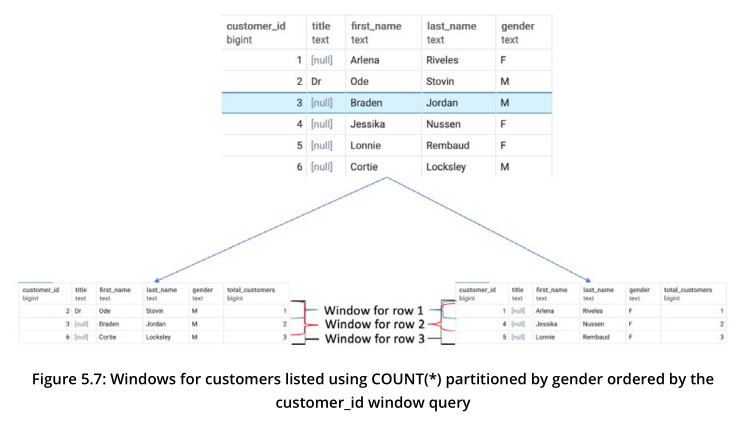

In [40]:
Image('images/window_count_1.PNG')

### Exercício 16: Analisando as taxas de preenchimento de dados do cliente ao longo do tempo
Nos últimos 6 meses, o ZoomZoom vem experimentando vários recursos para incentivar as pessoas a preencherem todos os campos do formulário do cliente, principalmente seu endereço. Para analisar esses dados, a empresa gostaria de um total de quantos usuários preencheram seu endereço ao longo do tempo. Escreva uma consulta para produzir esses resultados.

1. Abra seu cliente SQL favorito e conecte-se ao banco de dados **sqlda**.
2. Use as funções da janela e escreva uma consulta que retornará as informações do cliente e quantas pessoas preencheram seu endereço. Além disso, ordene a lista de acordo com a data. A consulta ficaria assim:

In [41]:
sql = """
      SELECT customer_id, street_address, date_added::DATE,
      COUNT(CASE WHEN street_address IS NOT NULL THEN customer_id ELSE NULL END)
      OVER (ORDER BY date_added::DATE) as total_customers_filled_street
      FROM customers
      ORDER BY date_added;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head(15)

,customer_id,street_address,date_added,total_customers_filled_street
0,35683,1 Cordelia Crossing,2010-03-15,10
1,30046,13961 Steensland Trail,2010-03-15,10
2,17099,130 Marcy Crossing,2010-03-15,10
3,2625,0353 Iowa Road,2010-03-15,10
4,30555,294 Quincy Hill,2010-03-15,10
5,18685,86 Michigan Junction,2010-03-15,10
6,13390,38463 Forest Dale Way,2010-03-15,10
7,7486,61 Village Crossing,2010-03-15,10
8,6173,79865 Hagan Terrace,2010-03-15,10
9,12484,None,2010-03-15,10


Agora temos todos os clientes ordenados por data de inscrição e podemos ver como o número de pessoas que preenchem o campo rua muda ao longo do tempo.

### A palavra-chave WINDOW
Agora que entendemos o básico das funções de janela, apresentaremos algumas sintaxes que tornarão mais fácil escrever funções de janela. Para algumas consultas, você pode estar interessado em calcular exatamente a mesma janela para diferentes funções. Por exemplo, você pode estar interessado em calcular um número total de clientes em execução e o número de clientes com um título em cada sexo com a seguinte consulta:

In [42]:
sql = """
      SELECT customer_id, title, first_name, last_name, gender,
      COUNT(*) OVER (PARTITION BY gender ORDER BY customer_id) as total_customers,
      SUM(CASE WHEN title IS NOT NULL THEN 1 ELSE 0 END)
        OVER (PARTITION BY gender ORDER BY customer_id) as total_customers_title
      FROM customers
      ORDER BY customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,gender,total_customers,total_customers_title
0,1,None,Arlena,Riveles,F,1,0
1,2,Dr,Ode,Stovin,M,1,1
2,3,None,Braden,Jordan,M,2,1
3,4,None,Jessika,Nussen,F,2,0
4,5,None,Lonnie,Rembaud,F,3,0


Embora a consulta forneça o resultado, pode ser tedioso escrever, especialmente a cláusula **WINDOW**. Existe uma maneira de simplificar? A resposta é sim, e isso é com outra cláusula **WINDOW**. A cláusula **WINDOW** facilita o alias de uma janela.

Com nossa consulta anterior, podemos simplificar a consulta escrevendo-a da seguinte maneira:

In [43]:
sql = """
      SELECT customer_id, title, first_name, last_name, gender,
      COUNT(*) OVER w as total_customers,
      SUM(CASE WHEN title IS NOT NULL THEN 1 ELSE 0 END)
        OVER w as total_customers_title
	  FROM customers
	  WINDOW w AS (PARTITION BY gender ORDER BY customer_id)
	  ORDER BY customer_id;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,customer_id,title,first_name,last_name,gender,total_customers,total_customers_title
0,1,None,Arlena,Riveles,F,1,0
1,2,Dr,Ode,Stovin,M,1,1
2,3,None,Braden,Jordan,M,2,1
3,4,None,Jessika,Nussen,F,2,0
4,5,None,Lonnie,Rembaud,F,3,0


Essa consulta deve fornecer o mesmo resultado visto anteriormente. No entanto, não tivemos que escrever uma longa consulta **PARTITION BY** e **ORDER BY** para cada função de janela. Em vez disso, simplesmente criamos um alias com a janela definida **w**.
## Estatísticas com funções de janela
Agora que entendemos como as funções de janela funcionam, podemos começar a usá-las para calcular estatísticas úteis, como classificações, percentis e estatísticas contínuas. Na tabela a seguir, resumimos uma variedade de funções estatísticas que são úteis. Também é importante enfatizar novamente que todas as funções agregadas também podem ser usadas como funções de janela (**AVG**, **SUM**, **COUNT** e assim por diante):

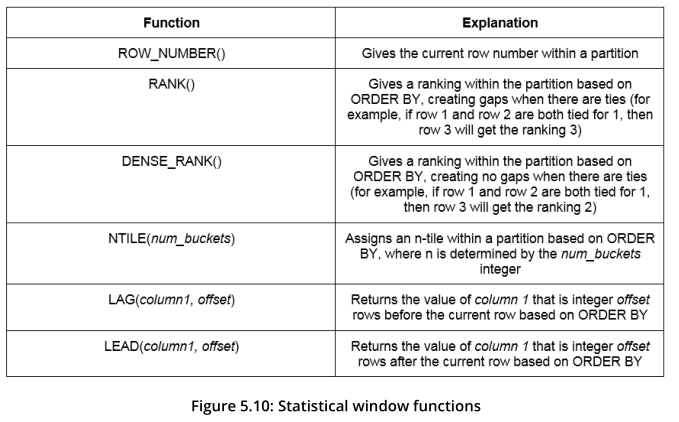

In [44]:
Image('images/statistical_window.PNG')

### Exercício 17: Ordem de Classificação de Contratação
A ZoomZoom gostaria de promover vendedores em suas concessionárias regionais para gerência e gostaria de considerar a estabilidade em sua decisão. Escreva uma consulta que classifique a ordem dos usuários de acordo com a data de contratação de cada concessionária:

1. Abra seu cliente SQL favorito e conecte-se ao banco de dados sqlda.
2. Calcule uma classificação para cada vendedor, com uma classificação de 1 para a primeira contratação, 2 para a segunda contratação e assim por diante, usando a função **RANK()**:

In [45]:
sql = """
      SELECT *,
      RANK() OVER (PARTITION BY dealership_id ORDER BY hire_date)
      FROM salespeople
      WHERE termination_date IS NULL;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,salesperson_id,dealership_id,title,first_name,last_name,suffix,username,gender,hire_date,termination_date,rank
0,65,1,None,Dukie,Oxteby,None,doxteby1s,Male,2015-01-24,None,1
1,74,1,None,Marcos,Spong,None,mspong21,Male,2015-03-18,None,2
2,60,1,None,Eveleen,Mace,None,emace1n,Female,2015-07-15,None,3
3,87,1,None,Quent,Wogden,None,qwogden2e,Male,2015-08-17,None,4
4,98,1,None,Englebert,Loraine,None,eloraine2p,Male,2016-01-23,None,5


Aqui, você pode ver todos os vendedores com suas informações e classificação na coluna de classificação com base na data de contratação de cada concessionária. Neste exercício, usamos a função **RANK()** para classificar os dados em um conjunto de dados em uma determinada ordem.

> ##### Observação
> DENSE_RANK() também pode ser usado tão facilmente quanto RANK().


### Window Frame
Quando discutimos os fundamentos das funções de janela, foi mencionado que, por padrão, uma janela é definida para cada linha para abranger todas as linhas da primeira linha na partição até a linha atual, como visto na Figura 5.5. No entanto, este é o padrão e pode ser ajustado usando a cláusula do **quadro de janela (Window Frame)**. Uma consulta de função do Windows usando a cláusula de quadro de janela teria a seguinte aparência:

`SELECT {columns},`

`{window_func} OVER (PARTITION BY {partition_key} ORDER BY {order_key}`

`{rangeorrows} BETWEEN {frame_start} AND {frame_end})`

`FROM {table1};`

Aqui, **{columns}** são as colunas a serem recuperadas das tabelas para a consulta, **{window_func}** é a função de janela que você deseja usar, **{partition_key}** é a coluna ou colunas nas quais você deseja particionar (mais sobre isso posteriormente), **{order_key}** é a coluna ou colunas pelas quais você deseja ordenar, **{rangeorrows}** é a palavra-chave RANGE *ou* a palavra-chave ROWS, **{frame_start}** é uma palavra-chave que indica onde iniciar o frame da janela, **{frame_end}** é uma palavra-chave que indica onde terminar o frame da janela e **{table1}** é a tabela ou tabelas unidas das quais você deseja extrair dados.

Um ponto de diferença a ser considerado é a diferença entre usar **RANGE** ou **ROW** em uma cláusula de quadro. **ROW** referem-se a linhas reais e levarão as linhas antes e depois da linha atual para calcular os valores. **RANGE** difere quando duas linhas têm os mesmos valores com base na cláusula **ORDER BY** usada na janela. Se a linha atual usada no cálculo da janela tiver o mesmo valor na cláusula ORDER BY que uma ou mais linhas, todas essas linhas serão adicionadas ao quadro da janela.

Outro ponto é considerar os valores que **{frame_start}** e **{frame_end}** podem assumir. Para fornecer mais detalhes, **{frame_start}** e **{frame_end}** podem ser um dos seguintes valores:

* **UNBOUNDED PRECEDING**: uma palavra-chave que, quando usada para **{frame_start}**, refere-se ao primeiro registro da partição e, quando usada para **{frame_end}**, refere-se ao último registro da partição
* **{offset} PRECEDING**: uma palavra-chave que se refere a linhas ou intervalos inteiros **{offset}** antes da linha atual
* **CURRENT ROW**: a linha atual
* **{offset}FOLLOWING**: uma palavra-chave que se refere a linhas ou intervalos inteiros **{offset}** após a linha atual

Ajustando a janela, várias estatísticas úteis podem ser calculadas. Uma dessas estatísticas úteis é a **média móvel (rolling average)**. A média móvel é simplesmente a média de uma estatística em uma determinada janela de tempo. Digamos que você queira calcular a média móvel de 7 dias de vendas ao longo do tempo para o ZoomZoom. Este cálculo pode ser realizado com a seguinte consulta:

In [46]:
sql = """
      WITH daily_sales as (
      SELECT sales_transaction_date::DATE,
      SUM(sales_amount) as total_sales
      FROM sales
      GROUP BY 1

      ),

      moving_average_calculation_7 AS (
      SELECT sales_transaction_date, total_sales,
      AVG(total_sales) OVER (ORDER BY sales_transaction_date ROWS BETWEEN 7
      PRECEDING and CURRENT ROW) AS sales_moving_average_7,
      ROW_NUMBER() OVER (ORDER BY sales_transaction_date) as row_number
      FROM daily_sales
      ORDER BY 1)

      SELECT sales_transaction_date,
      CASE WHEN row_number>=7 THEN sales_moving_average_7 ELSE NULL END
        AS sales_moving_average_7
      FROM moving_average_calculation_7;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,sales_transaction_date,sales_moving_average_7
0,2010-03-10,NaN
1,2010-03-12,NaN
2,2010-03-15,NaN
3,2010-03-17,NaN
4,2010-03-18,NaN


A razão pela qual as primeiras 7 linhas são nulas é que a média móvel de 7 dias só é definida se houver 7 dias de informações, e o cálculo da janela ainda calculará os valores dos primeiros 7 dias usando os primeiros dias.

### Exercício 18: Motivação do almoço em equipe
Para ajudar a melhorar o desempenho das vendas, a equipe de vendas decidiu pagar o almoço para todos os vendedores da empresa sempre que eles superassem o número de melhores ganhos totais diários alcançados nos últimos 30 dias. Escreva uma consulta que produza o total de vendas em dólares para um determinado dia e a meta que os vendedores devem atingir para esse dia, a partir de 1º de janeiro de 2019:

In [47]:
sql = """
      WITH daily_sales as (
        SELECT sales_transaction_date::DATE,
            SUM(sales_amount) as total_sales
        FROM sales
        GROUP BY 1
      ),
	 sales_stats_30 AS (
	 	 SELECT sales_transaction_date, total_sales,
	 	 MAX(total_sales) OVER (ORDER BY sales_transaction_date
	 	                                ROWS BETWEEN 30 PRECEDING AND 1 PRECEDING)
	 	 	 AS max_sales_30
	     FROM daily_sales
	     ORDER BY 1)

	 SELECT sales_transaction_date,
	        total_sales,
	        max_sales_30

	 FROM sales_stats_30
	 WHERE sales_transaction_date>='2019-01-01';
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,sales_transaction_date,total_sales,max_sales_30
0,2019-01-01,87694.844,316464.847
1,2019-01-02,76149.854,316464.847
2,2019-01-03,161269.809,316464.847
3,2019-01-04,193209.912,316464.847
4,2019-01-05,49469.770,316464.847


Observe o uso de uma **windows frame** de **30 PRECEDING** a **1 PRECEDING** para remover a linha atual do cálculo.

### Atividade 7: Analisando Vendas Usando Molduras de Janelas e Funções de Janela
É o feriado, e é hora de distribuir bônus de Natal no ZoomZoom. A equipe de vendas quer ver o desempenho geral da empresa, bem como o desempenho das concessionárias individuais dentro da empresa. Para conseguir isso, o chefe de vendas da ZoomZoom gostaria que você executasse uma análise para eles:
1. Abra seu cliente SQL favorito e conecte-se ao banco de dados sqlda.
2. Calcule o valor total de vendas por dia para todos os dias do ano de 2018 (ou seja, antes da data de 1º de janeiro de 2019).
3. Calcule a média móvel de 30 dias para o número diário de negócios de vendas.
4. Calcule em que decil cada concessionária estaria em comparação com outras concessionárias com base no valor total de vendas.

In [49]:
# Nº 2
sql = """
      SELECT sales_transaction_date::DATE,
      SUM(sales_amount) as total_sales_amount
      FROM sales
      WHERE sales_transaction_date>='2018-01-01'
      AND sales_transaction_date<'2019-01-01'
      GROUP BY 1
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,sales_transaction_date,total_sales_amount
0,2018-01-01,123689.951
1,2018-01-02,183859.790
2,2018-01-03,40029.854
3,2018-01-04,187119.878
4,2018-01-05,186459.904


In [50]:
# Nº 3
sql = """
      WITH daily_deals as (
                SELECT sales_transaction_date::DATE,
                COUNT(*) as total_deals
                FROM sales
                GROUP BY 1
                ),
          moving_average_calculation_30 AS (
                SELECT sales_transaction_date, total_deals,
                AVG(total_deals) OVER (ORDER BY sales_transaction_date
                    ROWS BETWEEN 30 PRECEDING and CURRENT ROW) AS deals_moving_average,
                ROW_NUMBER() OVER (ORDER BY sales_transaction_date) as row_number
                FROM daily_deals
                ORDER BY 1)

         SELECT sales_transaction_date,
                CASE WHEN row_number>=30 THEN deals_moving_average ELSE NULL END
                AS deals_moving_average_30
         FROM moving_average_calculation_30
         WHERE sales_transaction_date>='2018-01-01'
         AND sales_transaction_date<'2019-01-01';
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,sales_transaction_date,deals_moving_average_30
0,2018-01-01,17.935484
1,2018-01-02,18.354839
2,2018-01-03,18.354839
3,2018-01-04,18.129032
4,2018-01-05,17.935484


In [52]:
# Nº 4
sql = """
      WITH total_dealership_sales AS(
                    SELECT dealership_id,
                    SUM(sales_amount) AS total_sales_amount
                    FROM sales
                    WHERE sales_transaction_date>='2018-01-01'
                    AND sales_transaction_date<'2019-01-01'
                    AND channel='dealership'
                    GROUP BY 1
                    )
        SELECT *,
        NTILE(10) OVER (ORDER BY total_sales_amount)
        FROM total_dealership_sales;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,dealership_id,total_sales_amount,ntile
0,13.0,538079.414,1
1,9.0,618263.995,1
2,8.0,671619.251,2
3,4.0,905158.609,2
4,17.0,907058.842,3
